In [905]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv

load_dotenv()
file_path = os.getenv("FILE_PATH")
file_path

'C:/Users/joshu/OneDrive/Desktop/Practitioner Challenge/challenge'

In [906]:
SNP_prices_file = f'{file_path}/S&P 500 Index.csv'
SNP_VIX_file = f'{file_path}/S&P 500 VIX.csv'

### S&P500 Prices

In [948]:
# Load the CSV file into df
SNP = pd.read_csv(SNP_prices_file)
SNP.columns = ["date", "price"]
SNP["date"] = pd.to_datetime(SNP["date"])
SNP = SNP.set_index("date")
SNP = SNP.sort_index(ascending=True)

# Calculating log prices
SNP["log_returns"] = np.log(SNP["price"]/ SNP["price"].shift(1))
SNP = SNP[1:]
SNP.head()

,price,log_returns
date,,
2015-01-05,2020.58,-0.018447
2015-01-06,2002.61,-0.008933
2015-01-07,2025.90,0.011563
2015-01-08,2062.14,0.017730
2015-01-09,2044.81,-0.008439


In [908]:
# import plotly.express as px
# import plotly.graph_objects as go

# # Assuming SNP is your DataFrame with 'date' and 'log_returns' columns
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=SNP["date"], 
#     y=SNP["log_returns"], 
#     mode='lines+markers', 
#     name="S&P 500 Index"
# ))

# fig.update_layout(
#     title="S&P 500 Index Time Series",
#     xaxis_title="Date",
#     yaxis_title="Index Value",
#     xaxis=dict(rangeslider=dict(visible=True)),  # Adds a range slider for better navigation
#     template="plotly_white"  # Clean background
# )

# fig.show()

In [947]:
# Define start and end dates
SNP_training_start, SNP_training_end = "2015-01-02", "2022-12-31"
SNP_testing_start, SNP_testing_end = "2023-01-03", "2024-12-31"

# Filter the DataFrame
SNP_training_df = SNP[(SNP.index >= SNP_training_start) & (SNP.index <= SNP_training_end)]
SNP_testing_df = SNP[(SNP.index >= SNP_testing_start) & (SNP.index <= SNP_testing_end)]
SNP_training_df.head()

,price,log_returns
date,,
2015-01-05,2020.58,-0.018447
2015-01-06,2002.61,-0.008933
2015-01-07,2025.90,0.011563
2015-01-08,2062.14,0.017730
2015-01-09,2044.81,-0.008439


In [910]:
import pywt
import matplotlib.pyplot as plt
from scipy.stats import linregress

def hurst_wavelet(series, wavelet='db2', max_level=6):
    """
    Estimates the Hurst exponent using wavelet analysis.
    
    Parameters:
        series (pd.Series): Time series data (log returns or prices)
        wavelet (str): Type of wavelet (e.g., 'haar', 'db2')
        max_level (int): Maximum decomposition level

    Returns:
        float: Estimated Hurst exponent
    """

    # Ensure it's a NumPy array
    data = np.array(series)
    
    # Perform multi-level Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(data, wavelet, level=max_level)

    # Compute variances of detail coefficients at each level
    scales = np.array([2**i for i in range(1, len(coeffs))])  # Scale levels
    variances = np.array([np.var(c) for c in coeffs[1:]])  # Ignore approximation coefficients

    # Log-log regression to estimate H
    log_scales = np.log2(scales)
    log_variances = np.log2(variances)

    # Perform linear regression
    slope, intercept, _, _, _ = linregress(log_scales, log_variances)
    
    # Hurst exponent estimate (slope is related to H as H = (slope + 1)/2)
    hurst_exponent = (slope + 1) / 2

    # Plot Log-Log Variance vs. Scale
    plt.figure(figsize=(8, 5))
    plt.scatter(log_scales, log_variances, label="Wavelet Coeff Variances")
    plt.plot(log_scales, intercept + slope * log_scales, color='red', linestyle="--", label="Linear Fit")
    plt.xlabel("log2(Scale)")
    plt.ylabel("log2(Variance)")
    plt.title(f"Hurst Exponent Estimation (H = {hurst_exponent:.4f})")
    plt.legend()
    plt.grid()
    plt.show()

    return hurst_exponent

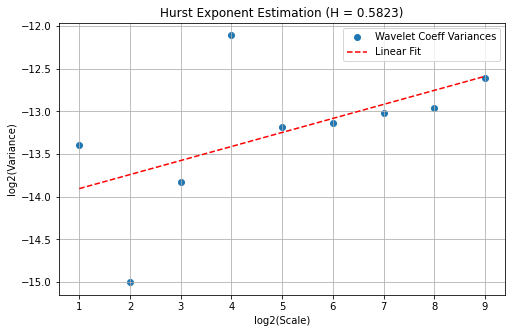

Estimated Hurst Exponent: 0.5823


In [911]:
# Example usage on S&P 500 log returns
SNP_hurst_est = hurst_wavelet(SNP_training_df["log_returns"], wavelet='haar', max_level=9)
print(f"Estimated Hurst Exponent: {SNP_hurst_est:.4f}")

In [912]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(series):
    """
    Performs ADF and KPSS tests on a time series.

    Parameters:
        series (pd.Series): The time series data.

    Returns:
        None (Prints test results)
    """
    # Augmented Dickey-Fuller Test (ADF)
    adf_result = adfuller(series, autolag='AIC')
    print("Augmented Dickey-Fuller Test Results:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value:.4f}")
    print("➡ Stationary" if adf_result[1] < 0.05 else "➡ Non-Stationary")

    print("\n" + "="*50 + "\n")

    # KPSS Test
    kpss_result = kpss(series, regression='c', nlags="auto")  # 'c' = constant (level stationarity)
    print("KPSS Test Results:")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"   {key}: {value:.4f}")
    print("➡ Non-Stationary" if kpss_result[1] < 0.05 else "➡ Stationary")

# Run the tests on S&P 500 log returns
stationarity_tests(SNP["log_returns"])

Augmented Dickey-Fuller Test Results:
ADF Statistic: -15.7254
p-value: 0.0000
Critical Values:
   1%: -3.4330
   5%: -2.8627
   10%: -2.5674
➡ Stationary


KPSS Test Results:
KPSS Statistic: 0.0495
p-value: 0.1000
Critical Values:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
➡ Stationary


c:\Users\joshu\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [913]:
from stochastic.processes.continuous import FractionalBrownianMotion
import numpy as np
import random
import plotly.graph_objects as go

def simulate_fbm_prices(train_data, test_data, H):
    """
    Simulate future stock prices using a geometric fractional Brownian motion model.
    
    Parameters:
        train_data (DataFrame): Training data containing columns 'price' and 'log_returns'.
        test_data (DataFrame): Testing data (used to determine the forecast horizon).
        H (float): Hurst exponent for the fBM model.
    
    Returns:
        np.ndarray: Array of simulated future prices.
    """
    # Set a fixed seed for reproducibility
    random.seed(42)
    np.random.seed(42)
    
    # Calculate drift (μ) and volatility (σ) from training log returns
    mu = train_data["log_returns"].mean()
    sigma = train_data["log_returns"].std()

    # Define Fractional Brownian Motion (fBM) model
    n_days = len(test_data)
    fbm = FractionalBrownianMotion(hurst=H, t=n_days - 1)
    fbm_values = fbm.sample(n=n_days - 1)
    
    # Use the last known price from training data as the starting point
    S0 = train_data['price'].iloc[-1]
    simulated_prices = S0 * np.exp(mu * np.arange(n_days) + sigma * fbm_values)
    
    return simulated_prices

def plot_actual_vs_simulated(test_data, simulated_prices, H):
    """
    Create an interactive Plotly plot comparing the actual prices with simulated prices.
    
    Parameters:
        test_data (DataFrame): DataFrame containing the actual price data with its index as dates.
        simulated_prices (np.ndarray): Array of simulated prices.
        H (float): Hurst exponent used in the simulation (for plot title).
    """
    # Create a Plotly figure
    fig = go.Figure()

    # Add actual price trace
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=test_data["price"],
        mode='lines',
        name='Actual Price',
        line=dict(color='blue')
    ))

    # Add simulated (forecasted) price trace
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=simulated_prices,
        mode='lines',
        name='Forecasted Price (fBM)',
        line=dict(color='red', dash='dash')
    ))

    # Update layout of the plot
    fig.update_layout(
        title=f"Stock Price Forecast using fBM (H={H})",
        xaxis_title="Date",
        yaxis_title="Stock Price",
        template="plotly_white"
    )
    
    # Display the plot
    fig.show()

# Example usage:
simulated_prices = simulate_fbm_prices(SNP_training_df, SNP_testing_df, SNP_hurst_est)
plot_actual_vs_simulated(SNP_testing_df, simulated_prices, SNP_hurst_est)

In [914]:
def montecarlo_simulation_and_plot(train_data, test_data, H, num_simulations=100):
    """
    Perform a Monte Carlo simulation by generating multiple fBM price paths and plot them 
    alongside the actual stock prices.
    
    Parameters:
        train_data (DataFrame): Training data containing columns 'price' and 'log_returns'.
        test_data (DataFrame): Testing data (used to determine the forecast horizon).
        H (float): Hurst exponent for the fBM model.
        num_simulations (int): Number of simulation paths to generate.
    """
    # Set seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    
    # Calculate drift (μ) and volatility (σ) from training log returns
    mu = train_data["log_returns"].mean()
    sigma = train_data["log_returns"].std()
    
    n_days = len(test_data)
    time_points = np.arange(n_days)
    S0 = train_data['price'].iloc[-1]
    
    simulation_paths = []
    
    for i in range(num_simulations):
        # For each simulation, sample a new fBM path
        fbm = FractionalBrownianMotion(hurst=H, t=n_days - 1)
        fbm_values = fbm.sample(n=n_days - 2)
        fbm_values = np.insert(fbm_values, 0, 0)  # align with the time vector
        sim_prices = S0 * np.exp(mu * time_points + sigma * fbm_values)
        simulation_paths.append(sim_prices)
    
    # Create a Plotly figure for the Monte Carlo simulation
    fig = go.Figure()
    
    # Add each simulated path (using low opacity to avoid clutter)
    for i, sim_prices in enumerate(simulation_paths):
        fig.add_trace(go.Scatter(
            x=test_data.index,
            y=sim_prices,
            mode='lines',
            name=f'Simulation {i+1}',
            line=dict(color='rgba(255, 0, 0, 0.1)'),  # Red with transparency
            showlegend=False  # Hide individual simulation legends
        ))
    
    # Overlay the actual prices
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=test_data["price"],
        mode='lines',
        name='Actual Price',
        line=dict(color='blue', width=2)
    ))
    
    # Update plot layout
    fig.update_layout(
        title=f"Monte Carlo Simulation of Stock Prices using fBM (H={H}) - {num_simulations} Paths",
        xaxis_title="Date",
        yaxis_title="Stock Price",
        template="plotly_white"
    )
    
    fig.show()

montecarlo_simulation_and_plot(SNP_training_df, SNP_testing_df, SNP_hurst_est, num_simulations=100)

### S&P500 VIX Analysis

In [915]:
# Load the CSV file into df
VIX = pd.read_csv(SNP_VIX_file)
VIX.columns = ["vol"]
VIX["log_vol_diff"] = np.log(VIX['vol']/ VIX['vol'].shift(1))
VIX.index = pd.to_datetime(VIX.index)
VIX = VIX.sort_index(ascending=True)
VIX = VIX[1:]
VIX['log_vol'] = np.log(VIX['vol'])

VIX.head()

,vol,log_vol_diff,log_vol
2015-01-05,19.92,-0.058496,2.991724
2015-01-06,21.12,0.089597,3.050220
2015-01-07,19.31,0.126822,2.960623
2015-01-08,17.01,-0.031253,2.833801
2015-01-09,17.55,-0.110476,2.865054


In [920]:
# vix_training_start, vix_training_end = "2015-01-02", "2022-12-30"
vix_training_start, vix_training_end = "2018-01-01", "2020-06-30"
vix_testing_start, vix_testing_end = "2020-07-01", "2020-08-01"

vix_training_df = VIX[(VIX.index >= vix_training_start) & (VIX.index <= vix_training_end)]
vix_testing_df = VIX[(VIX.index >= vix_testing_start) & (VIX.index <= vix_testing_end)]
vix_training_df.head()

,vol,log_vol_diff,log_vol
2018-01-02,9.77,0.065563,2.279316
2018-01-03,9.15,-0.007621,2.213754
2018-01-04,9.22,0.000000,2.221375
2018-01-05,9.22,-0.032020,2.221375
2018-01-08,9.52,-0.057158,2.253395


In [917]:
from hurst import compute_Hc

vix_hurst_est, c, data = compute_Hc(vix_training_df["log_vol"], kind='change', simplified=True)
print(f"Estimated Hurst Exponent: {vix_hurst_est:.4f}")

Estimated Hurst Exponent: 0.6277


In [946]:
from stochastic.processes.continuous import FractionalBrownianMotion
import numpy as np
import random
import plotly.graph_objects as go

def simulate_fbm_vix(train_data, test_data, H):
    """
    Simulates a VIX path using geometric fractional Brownian motion.
    
    Parameters:
        train_data (DataFrame): Training data containing at least 'vol' and 'log_vol_diff'.
        test_data (DataFrame): Testing data to determine the simulation length.
        H (float): Hurst exponent for the fractional Brownian motion.
        
    Returns:
        np.ndarray: Simulated VIX values.
    """
    # Set fixed seeds for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Calculate drift (μ) and volatility (σ) from training log differences of VIX
    mu = train_data["log_vol_diff"].mean()
    sigma = train_data["log_vol_diff"].std()

    n_days = len(test_data)
    # Define and sample from the fBM model
    fbm = FractionalBrownianMotion(hurst=H, t=n_days-1)
    fbm_values = fbm.sample(n=n_days-1)

    # Use the last available VIX value in training data as the starting point
    S0 = train_data['vol'].iloc[-1]
    # Simulate the VIX path using a geometric fBM model
    simulated_vix = S0 * np.exp(mu * np.arange(n_days) + sigma * fbm_values)
    print(mu, sigma)
    return simulated_vix

def plot_fbm_vix(test_data, simulated_vix, H):
    """
    Plots actual vs. simulated VIX values.
    
    Parameters:
        test_data (DataFrame): Testing data containing actual VIX values under 'vol'.
        simulated_vix (np.ndarray): Simulated VIX values.
        H (float): Hurst exponent used in the simulation (for labeling purposes).
    """
    fig = go.Figure()

    # Actual VIX trace
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=test_data["vol"],
        mode='lines',
        name='Actual VIX',
        line=dict(color='blue')
    ))

    # Forecasted VIX trace using fBM
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=simulated_vix,
        mode='lines',
        name='Forecasted VIX (fBM)',
        line=dict(color='red', dash='dash')
    ))

    # Update layout of the plot
    fig.update_layout(
        title=f"VIX Forecast using fBM (H={H})",
        xaxis_title="Date",
        yaxis_title="VIX Value",
        template="plotly_white"
    )

    fig.show()

# Example usage:
simulated_vix = simulate_fbm_vix(vix_training_df, vix_testing_df, vix_hurst_est)
plot_fbm_vix(vix_testing_df, simulated_vix, vix_hurst_est)


-0.0017060147747200226 0.09294785307769589


In [919]:
import pandas as pd
import numpy as np
from hurst import compute_Hc

def compute_rolling_hurst(df, window, col='log_vol_diff', lag=0):
    hurst_values = []
    times = []
    
    # Loop through the DataFrame using the rolling window
    for i in range(window - 1, len(df), lag+1):
        # Extract the window slice from the series
        window_series = df[col].iloc[i - window + 1 : i + 1]
        # Compute the Hurst exponent using the 'change' method and simplified calculation
        h, c, data = compute_Hc(window_series, kind='change', simplified=True)
        
        hurst_values.append(h)
        times.append(df.index[i])
    
    # Create and return a new DataFrame with the computed Hurst exponents
    result_df = pd.DataFrame({'hurst': hurst_values}, index=times)
    return result_df

rolling_hurst_150 = compute_rolling_hurst(VIX, window=150, col='log_vol', lag=6)
rolling_hurst_350 = compute_rolling_hurst(VIX, window=350, col='log_vol', lag=6)
rolling_hurst_500 = compute_rolling_hurst(VIX, window=500, col='log_vol', lag=6)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=rolling_hurst_150.index,
    y=rolling_hurst_150["hurst"],
    mode='lines',
    name='150 days rolling window',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=rolling_hurst_350.index,
    y=rolling_hurst_350["hurst"],
    mode='lines',
    name='350 days rolling window',
    line=dict(color='red')
))
fig.add_trace(go.Scatter(
    x=rolling_hurst_500.index,
    y=rolling_hurst_500["hurst"],
    mode='lines',
    name='500 days rolling window',
    line=dict(color='green')
))
fig.update_layout(
    title=f"Hurst exponent for volatility",
    xaxis_title="Date",
    yaxis_title="Hurst Value",
    template="plotly_white"
)
